# Sentiment Analysis

Sentiment analysis refers to the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information. The purpose of this notebook is to perform a sentiment analysis on [this dataset from Kaggle](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) which contains 50,000 movie reviews.

## Import the modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from wordcloud import WordCloud

Check the data for any null values. This takes out errors that are related to nan values. A value of false means that there's no null value in the dataset.

In [2]:
df = pd.read_csv('IMDB Dataset.csv')
df.isnull().values.any()

False

## Data distribution
Check the distribution of data. Ideally, the distribution of data between classes should be equal. Having a balanced data eliminates the issue of the algorithm forming a bias against the less frequent class. This also allows the use of easily interpretable evaluation metrics like accuracy. The result below shows that the data is evenly split between negative and positive classes.

In [3]:
data_comp = df.groupby('sentiment').count()
data_comp

,review
sentiment,
negative,25000
positive,25000


#### Create a pie chart for the data distribution

In [4]:
def pie_chart(labels, sizes):
    explode = (0.01, 0.01)  # only "explode" the 2nd slice (i.e. 'Hogs')
    plt.style.use('seaborn-muted')
    fig1, ax1 = plt.subplots(dpi = 100, figsize = (4, 4))
    ax1.pie(sizes, labels=labels, explode = explode, autopct='%1.1f%%', startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

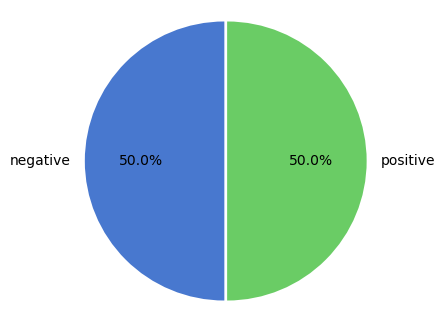

In [5]:
pie_chart(data_comp.index, data_comp['review'])

## Data cleaning
This preprocesses the text so that the it can be easily understood by machine learning algorithms. The function 'cleaner' does the preprocessing of each input 'row'.

In [6]:
def cleaner(row):
    row = row.lower() #set all the strings to lowercase
    row = re.sub('<.+>', '', row) #remove html tags
    row = re.sub('\W+', ' ', row) #remove special characters
    row = re.sub('http\S+|www.\S+', '', row) #remove links
    return row

In [7]:
# Perform the function 'cleaner' on each row of the dataframe
df2 = df.copy()
df2['review'] = df2['review'].apply(cleaner)
df2.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the realism real...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there s a family where a little boy ...,negative
4,petter mattei s love in the time of money is a...,positive


LabelEncoder transforms 'positive' and 'negative' results from the sentiment column to 1 and 0, respectively.

In [8]:
lb = LabelEncoder()
df2['sentiment'] = lb.fit_transform(df2['sentiment']).astype('int')
df2.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the realism real...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there s a family where a little boy ...,0
4,petter mattei s love in the time of money is a...,1


Assign X as the input variable and Y as the output variable.

In [9]:
X = df2['review'] # This will serve as features
Y = df2['sentiment']

## Train and test data
Split the dataset into train and test subsets. The default values of the partition between the train and test sets are used below, which are 0.75 and 0.25, respectively. The 'random_state' is set to 0 for reproducible results.

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0, test_size = 0.2)

## Vectorizer
The Term Frequency Inverse Document Frequency or TF-IDF is used as the vectorizer. The basic idea is that high weights are given to words that appear frequently in a document but appear few in the corpus. Low weights are given to words that appear frequently in the corpus, this gives stop words less meaning. TF-IDF is more suitable for a large dataset like this one instead of the Count Vectorizer, since the latter only counts the number of times a word appears in a document.

Set ngram_range is the range of sets of consecutive words. At the minimum, it captures single words, and at the maximum, it captures sets of 3 consecutive words.
Min_df is the minimum number of times a word needs to appear in a document before it can be included in the corpus.
Max_df is the maximum number of times a word needs to appear in a document before it can be included in the corpus.
Strip_accents removes character accents from strings.

In [11]:
cv = TfidfVectorizer(ngram_range = (1, 3), min_df = 5, max_df = 0.2, stop_words = 'english', strip_accents = 'unicode')

# Fit the vectorizer to the training set. Transform converts the words into a sparse matrix. 
# Any words that is in the test set that did not appeared in the train set will be ignored. 
X_train_vector = cv.fit_transform(X_train)

## Word cloud
A word cloud is a data visualization tool that is a collection of words displayed in different sizes. The word with the biggest font has the highest weight given by the TF-IDF vectorizer, while a word with a small font only has a small weight.
### Get the top 100 words with the highest weights

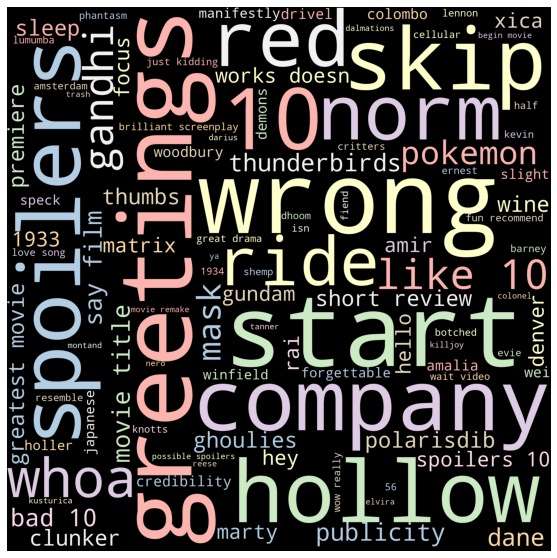

In [12]:
# Get the feature names
f_names = np.array(cv.get_feature_names())

# Sort the index of the weights of the feature names
weights = X_train_vector.max(0).toarray()[0].argsort()

# Get the top 100 words with the highest weights given by the TD-IDF vectorizer
heavy_dict = dict(zip(f_names[weights[:-101:-1]], sorted(X_train_vector.max(0).toarray()[0])[:-101:-1]))

# Generate the word cloud
wc_b = WordCloud(width = 2000, height = 2000, background_color = 'black', colormap = 'Pastel1').generate_from_frequencies(heavy_dict)
plt.figure(figsize = (10, 10))
plt.imshow(wc_b)
plt.axis(False)
plt.show()

### Get the top 100 words with the lowest weights

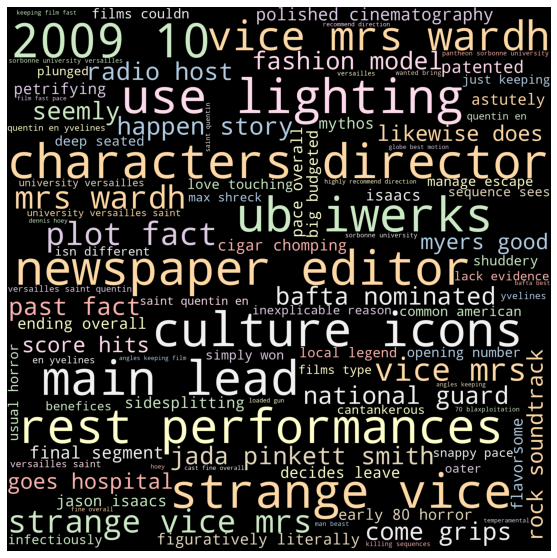

In [13]:
# Get the top 100 words with the lowest weights given by the TD-IDF vectorizer
heavy_dict = dict(zip(f_names[weights[:100]], sorted(X_train_vector.max(0).toarray()[0])[:100]))

# Generate the word cloud
wc_l = WordCloud(width = 2000, height = 2000, background_color = 'black', colormap = 'Pastel1').generate_from_frequencies(heavy_dict)
plt.figure(figsize = (10, 10))
plt.imshow(wc_l)
plt.axis(False)
plt.show()

## Baseline score
A dummy classifier is used to have a baseline score. The default strategy is used, which is stratified, for the dummy classifier since the distribution of the positive and negative reviews are equal. The dummy classifier serves as a sanity check for the classifier that will be used to train and test the data.

In [14]:
cls_d = DummyClassifier(strategy = 'stratified') # Instantiate the dummy classifier
cls_d.fit(X_train_vector, Y_train) # Train the model
pred = cls_d.predict(cv.transform(X_test)) # Predict the test test data

## Accuracy
Accuracy is the evaluation metric used due to the fact that the data is balanced and it is easier to interpret compared to other evaluation metrics like ROC-AUC, F1 score, etc.

In [15]:
acc_dum = accuracy_score(Y_test, pred)
print(f'Accuracy of Dummy Classifier is {(acc_dum * 100):.2f}%')

Accuracy of Dummy Classifier is 50.90%


## Classification
The 3 most common classification for sentiment analysis are going to be evaluated against each other. The evaluation metric is accuracy.

## Logistic Regression

In [16]:
clf_lr = LogisticRegression(n_jobs = -1)
clf_lr.fit(X_train_vector, Y_train)
acc_lr = clf_lr.score(cv.transform(X_test), Y_test)
print(f'Accuracy of Logistic Regression is {(acc_lr * 100):.2f}%')

Accuracy of Logistic Regression is 85.93%


## Multinomial Naive Bayes

In [17]:
clf_nb = MultinomialNB(alpha = 0.1)
clf_nb.fit(X_train_vector, Y_train)
acc_nb = clf_nb.score(cv.transform(X_test), Y_test)
print(f'Accuracy of Multinomial Naive Bayes is {(acc_nb * 100):.2f}%')

Accuracy of Multinomial Naive Bayes is 85.00%


## Support Vector Classifier

In [18]:
clf_svc = SVC()
clf_svc.fit(X_train_vector, Y_train)
acc_svc = clf_nb.score(cv.transform(X_test), Y_test)
print(f'Accuracy of Support Vector Classifier is {(acc_nb * 100):.2f}%')

Accuracy of Support Vector Classifier is 85.00%


## Plot the accuracy

#### Create a function for the accuracy comparison

In [19]:
# Map the accuracy with the corresponding classifier
label = ['Dummy Classifier (Baseline)', 'Logistic Regression', 'Multinomial Naive Bayes', 'Supper Vector Classifier']
acc = [acc_dum, acc_lr, acc_nb, acc_svc]
acc_dict = dict(zip(label, acc))

In [20]:
def compare(di, metric):
    y = [i for i in range(len(di))]
        
    for idx, val in enumerate(metric):
        fig, ax = plt.subplots(dpi = 100, figsize = (6, 4))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_yticks(y)
        ax.set_yticklabels(list(di.keys()))

        for i in range(len(di)):
            ax.text(list(di.values())[i] * 100, y[i], f'{(list(di.values())[i] * 100):.2f}%')
            plt.barh(y[i], list(di.values())[i] * 100, height = 0.5, align = 'center')

        plt.style.use('seaborn-muted')
        plt.tick_params(axis='both', length = 0)
        plt.suptitle(f'Test {val}', x = 0.51, y = 0.98)
        plt.xlabel(f'% {val}')

        if val == 'Loss':
            plt.title('(Lower is better)', fontsize=10)
        else:
            plt.title('(Higher is better)', fontsize=10)

        plt.show()   

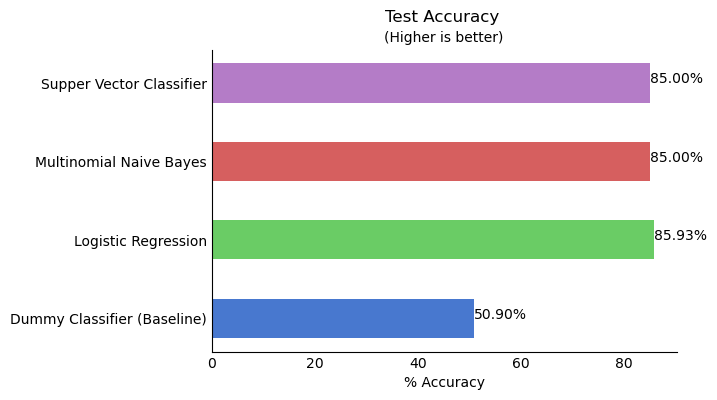

In [21]:
compare(acc_dict, metric =['Accuracy'])

## Summary
* Applied text preprocessing techniques to the dataset
* Demonstrated sentiment analysis using Logistic Regression, Multinomial Naive Bayes, and Support Vector Classifier
* Logistic Regression has the highest accuracy with 85.93%

## Improvements

* Tweak the hyperparameters of the machine learning algorithms
* Use deep learning to classify the dataset